In [1]:
# Model 1: https://www.kaggle.com/devm2024/transfer-learning-with-vgg-16-cnn-aug-lb-0-1712
# Model 2: https://www.kaggle.com/vincento/keras-starter-4l-0-1694-lb-icebergchallenge
# Model 3: https://www.kaggle.com/bluevalhalla/fully-convolutional-network-lb-0-193

# ResNet50
# InceptionV3
# MobileNet
# DenseNet
# SqueezeNet
# InceptionResNetV2
# Xception
# LeNet

# Simple model: https://www.kaggle.com/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d
# https://www.kaggle.com/henokanh/cnn-batchnormalization-0-1646
# https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl
# https://www.kaggle.com/cttsai/ensembling-gbms-lb-203/code
# https://www.kaggle.com/yuhaichina/single-model-vgg16-mobilenet-lb-0-1568-with-tf
# https://www.kaggle.com/wvadim/keras-tf-lb-0-18
# https://www.kaggle.com/yekenot/inceptionv3-k-fold-cv-lb-0-1944


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from os.path import join as opj
import keras
import abc
import cv2

from mpl_toolkits.mplot3d import Axes3D

#Import Keras.
#from matplotlib import pyplot
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
train = pd.read_json("../_RawData/train.json/data/processed/train.json")
test = pd.read_json("../_RawData/test.json/data/processed/test.json")

In [3]:
class Helpers():
    def get_angledata(train, test):
        train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
        train['inc_angle']=train['inc_angle'].fillna(method='pad')
        test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')

        X_angle=train['inc_angle']
        X_test_angle=test['inc_angle']
        
        angle_min = np.minimum(X_angle.min(), X_test_angle.min())
        angle_max = np.maximum(X_angle.max(), X_test_angle.max())
        
        X_angle = (X_angle - angle_min) / (angle_max - angle_min)
        X_test_angle = (X_test_angle - angle_min) / (angle_max - angle_min)
        
        return X_angle, X_test_angle
    
    def get_banddata(data):
        X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_1"]])
        X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_2"]])
#         X_band_3=np.fabs(np.subtract(X_band_1,X_band_2))
        X_band_3 = (X_band_1 + X_band_2) / 2
        X_band_4=np.maximum(X_band_1,X_band_2)
        X_band_5=np.minimum(X_band_1,X_band_2)
        
        return X_band_1, X_band_2, X_band_3, X_band_4, X_band_5

    def get_imagedata(train, test):
        X_band_train_1, X_band_train_2, X_band_train_3, X_band_train_4, X_band_train_5 = Helpers.get_banddata(train)
        X_band_test_1, X_band_test_2, X_band_test_3, X_band_test_4, X_band_test_5 = Helpers.get_banddata(test)
        
#         print(X_band_3.shape)
#         print(X_band_4.shape)
#         print(X_band_5.shape)
#         print(X_band_test_3.shape)
        
        
        
        band_3_min = np.minimum(X_band_train_3.min(), X_band_test_3.min())
        band_4_min = np.minimum(X_band_train_4.min(), X_band_test_4.min())
        band_5_min = np.minimum(X_band_train_5.min(), X_band_test_5.min())

        band_3_max = np.maximum(X_band_train_3.max(), X_band_test_3.max())
        band_4_max = np.maximum(X_band_train_4.max(), X_band_test_4.max())
        band_5_max = np.maximum(X_band_train_5.max(), X_band_test_5.max())
        
#         print(band_3_min)
#         print(band_4_min)
#         print(band_5_min)
#         print(band_3_max)
#         print(band_4_max)
#         print(band_5_max)

        X_band_train_3 = (X_band_train_3 - band_3_min) / (band_3_max - band_3_min)
        X_band_train_4 = (X_band_train_4 - band_4_min) / (band_4_max - band_4_min)
        X_band_train_5 = (X_band_train_5 - band_5_min) / (band_5_max - band_5_min)
        
        X_band_test_3 = (X_band_test_3 - band_3_min) / (band_3_max - band_3_min)
        X_band_test_4 = (X_band_test_4 - band_4_min) / (band_4_max - band_4_min)
        X_band_test_5 = (X_band_test_5 - band_5_min) / (band_5_max - band_5_min)
        
        X_band_train_3 = X_band_train_3
        X_band_train_4 = X_band_train_4
        X_band_train_5 = X_band_train_5
        X_band_test_3 = X_band_test_3
        X_band_test_4 = X_band_test_4
        X_band_test_5 = X_band_test_5
        
        X_band_train = np.concatenate([X_band_train_3[:, :, :, np.newaxis],X_band_train_4[:, :, :, np.newaxis],X_band_train_5[:, :, :, np.newaxis]], axis=-1)
        X_band_test = np.concatenate([X_band_test_3[:, :, :, np.newaxis],X_band_test_4[:, :, :, np.newaxis],X_band_test_5[:, :, :, np.newaxis]], axis=-1)

        return X_band_train, X_band_test
    
    def get_generator():
        # Define the image transformations here
        return ImageDataGenerator(horizontal_flip = True,
                                 vertical_flip = True,
                                 width_shift_range = 0.,
                                 height_shift_range = 0.,
                                 channel_shift_range=0,
                                 zoom_range = 0.2,
                                 rotation_range = 10)
    
    # Here is the function that merges our two generators
    # We use the exact same generator with the same random seed for both the y and angle arrays
    def gen_flow_for_two_inputs(X1, X2, y, batch_size = 64):
        gen = Helpers.get_generator()
        genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
        genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
        while True:
                X1i = genX1.next()
                X2i = genX2.next()
                #Assert arrays are equal - this was for peace of mind, but slows down training
                #np.testing.assert_array_equal(X1i[0],X2i[0])
                yield [X1i[0], X2i[1]], X1i[1]
                
    # Here is the function that merges our two generators
    # We use the exact same generator with the same random seed for both the y and angle arrays
    def gen_flow_for_one_input(X1, y, batch_size = 64):
        gen = Helpers.get_generator()
        genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
        return genX1
                

    # Finally create generator
    def get_callbacks(filepath, patience=2):
#         es = EarlyStopping('val_loss', patience=10, mode="min")
        es = EarlyStopping('val_loss', patience=15, mode="min")
        msave = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')
#         reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, epsilon=1e-4, mode='min')
        return [es, msave, reduce_lr_loss]

In [4]:
target_train=train['is_iceberg']
X_angle, X_test_angle = Helpers.get_angledata(train, test)
X_train, X_test = Helpers.get_imagedata(train, test)
ids = test['id']

In [5]:
class ModelBase():
    __metaclass__ = abc.ABCMeta
    
    def __init__(self, ids = None):
        self.batch_size = 64
        self.epochs = 100
        self.ids = ids
        self.predictions = None
        self.K = 5
        
        self.model = self.get_model()
        
    def save_model(self):
        name = self.get_name() + datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S') + ".h5"
        self.model.save_weights(name)
        
    def create_submission(self, predict):
        submission = pd.DataFrame()
        submission['id']=test['id']
        submission['is_iceberg']=preds
        submission.to_csv("submission-" + self.get_name() + ".csv", float_format='%g', index = False)
    
    @abc.abstractmethod
    def get_model(self):
        pass

    @abc.abstractmethod
    def get_name(self):
        pass
    
    def get_size(self):
        return -1
    
        
    #Using K-fold Cross Validation with Data Augmentation.
    def train_predict(self, X_train, X_angle, X_test, target_train):
        img_size = self.get_size()
        
        X_train_resized = X_train
        X_test_resized = X_test
            
        if img_size > 0:
            X_train_resized = np.empty(shape = (X_train.shape[0], img_size, img_size, 3))
            X_test_resized = np.empty(shape = (X_test.shape[0], img_size, img_size, 3))
            count = 0
            for img in X_train:
                new_img = cv2.resize(img, (img_size, img_size))
                X_train_resized[count] = new_img
                count += 1

            count = 0
            for img in X_test:
                new_img = cv2.resize(img, (img_size, img_size))
                X_test_resized[count] = new_img
                count += 1
                
        print("Orig:", X_train.shape)
        print("Resized:", X_train_resized.shape)

        folds = list(StratifiedKFold(n_splits=self.K, shuffle=True, random_state=16).split(X_train_resized, target_train))
        y_test_pred_log = 0
        y_train_pred_log=0
        y_valid_pred_log = 0.0*target_train
        for j, (train_idx, test_idx) in enumerate(folds):
            print('\n===================FOLD=',j)
            X_train_cv = X_train_resized[train_idx]
            y_train_cv = target_train[train_idx]
            X_holdout = X_train_resized[test_idx]
            Y_holdout= target_train[test_idx]

            #Angle
            X_angle_cv=X_angle[train_idx]
            X_angle_hold=X_angle[test_idx]

            #define file path and get callbacks
            file_path = "%s_"%j + self.get_name() + ".hdf5"
            callbacks = Helpers.get_callbacks(filepath=file_path, patience=5)
            gen_flow = Helpers.gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
            
            galaxyModel = self.get_model()
            
#             if galaxyModel.model is not None:
#                 input_shape = len(galaxyModel.model.input_shape)
#             else:
            input_shape = len(galaxyModel.input_shape)
                
            train_array = [X_train_resized,X_angle]
            train_array_cv = [X_train_cv,X_angle_cv]
            holdout_array = [X_holdout,X_angle_hold]
            test_array = [X_test_resized, X_test_angle]
            
            if input_shape != 2:
                train_array = X_train_resized
                train_array_cv = X_train_cv
                holdout_array = X_holdout
                test_array = X_test_resized
                gen_flow = Helpers.gen_flow_for_one_input(X_train_cv, y_train_cv)
                
            galaxyModel.fit_generator(
                    gen_flow,
                    steps_per_epoch=24,
                    epochs=self.epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=(holdout_array, Y_holdout),
                    callbacks=callbacks)

            #Getting the Best Model
            galaxyModel.load_weights(filepath=file_path)
            #Getting Training Score
            score = galaxyModel.evaluate(train_array_cv, y_train_cv, verbose=0)
            print('Train loss:', score[0])
            print('Train accuracy:', score[1])
            #Getting Test Score
            score = galaxyModel.evaluate(holdout_array, Y_holdout, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            #Getting validation Score.
            pred_valid=galaxyModel.predict(holdout_array)
            y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

            #Getting Test Scores
            temp_test=galaxyModel.predict(test_array)
            y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

            #Getting Train Scores
            temp_train=galaxyModel.predict(train_array)
            y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

        y_test_pred_log=y_test_pred_log/self.K
        y_train_pred_log=y_train_pred_log/self.K

        print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
        print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
        
#         self.plot_results
        self.create_submission(preds)
        
        self.predictions = y_test_pred_log 
        return y_test_pred_log
    
#     def plot_results(self):
#         plt.plot(self.history['acc'])
#         plt.plot(self.history['val_acc'])
#         plt.title('model accuracy')
#         plt.ylabel('accuracy')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper left')
#         plt.show()
#         # summarize history for loss
#         plt.plot(self.history['loss'])
#         plt.plot(self.history['val_loss'])
#         plt.title('model loss')
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper left')
#         plt.show()
        

In [6]:
class VggModel(ModelBase):
    def get_model(self):
        input_2 = Input(shape=[1], name="angle")
        angle_layer = Dense(1, )(input_2)
        base_model = VGG16(weights='imagenet', include_top=False, 
                     input_shape=X_train.shape[1:], classes=1)
        x = base_model.get_layer('block5_pool').output

        x = GlobalMaxPooling2D()(x)
        merge_one = concatenate([x, angle_layer])
        merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
        merge_one = Dropout(0.3)(merge_one)
        merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
        merge_one = Dropout(0.3)(merge_one)

        predictions = Dense(1, activation='sigmoid')(merge_one)

        model = Model(input=[base_model.input, input_2], output=predictions)

        sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='binary_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])
        return model

    def get_name(self):
        return "vgg16"

In [7]:
class SimpleModel(ModelBase):
    def get_model(self):
        base_model=Sequential()

        # CNN 1
        base_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
        base_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        base_model.add(Dropout(0.2))

        # CNN 2
        base_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
        base_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        base_model.add(Dropout(0.2))

        # CNN 3
        base_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        base_model.add(Dropout(0.3))

        #CNN 4
        base_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        base_model.add(Dropout(0.3))

        # You must flatten the data for the dense layers
        base_model.add(Flatten())

        #Dense 1
        base_model.add(Dense(512, activation='relu'))
        base_model.add(Dropout(0.2))

        #Dense 2
        base_model.add(Dense(256, activation='relu'))
        base_model.add(Dropout(0.2))

        # Output 
        base_model.add(Dense(1, activation="sigmoid"))

        optimizer = Adam(lr=0.001, decay=0.0)
        base_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return base_model

    def get_name(self):
        return "simple"

In [8]:
class BatchNormModel(ModelBase):
    def ConvBlock(model, layers, filters):
        '''Create [layers] layers consisting of zero padding, a convolution with [filters] 3x3 filters and batch normalization. Perform max pooling after the last layer.'''
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Conv2D(filters, (3, 3), activation='relu'))
            model.add(BatchNormalization(axis=3))

        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    def get_model(self):
        model = Sequential()

        # Input image: 75x75x3
        model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
        BatchNormModel.ConvBlock(model, 1, 32)
        # 37x37x32
        BatchNormModel.ConvBlock(model, 1, 64)
        # 18x18x64
        BatchNormModel.ConvBlock(model, 1, 128)
        # 9x9x128
        BatchNormModel.ConvBlock(model, 1, 128)
        # 4x4x128
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(2, (3, 3), activation='relu'))
        model.add(GlobalAveragePooling2D())
        # 4x4x2
        model.add(Dense(1, activation = 'sigmoid'))
        
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

        return model

    def get_name(self):
        return "batchnorm"

In [9]:
from keras.applications import MobileNet

class MobileNetModel(ModelBase):
    def get_model(self):
        image_size = self.get_size()
        img_input = keras.layers.Input(shape=(image_size, image_size, 3))
        mobile_model = MobileNet(input_tensor = img_input, weights=None, alpha=1.0, include_top=True, classes=1)

        optimizer = Adam(lr=0.001)
        mobile_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        
        return mobile_model

    def get_name(self):
        return "mobilenet"
    
    def get_size(self):
        return 128

In [10]:
from keras.applications import InceptionV3

class InceptionV3Model(ModelBase):
    def get_model(self):
        input_tensor = Input(shape=(self.get_size(), self.get_size(), 3))
        base_model = InceptionV3(include_top=False,
                       weights=None,
                       input_shape=(self.get_size(), self.get_size(), 3))
        
        bn = BatchNormalization()(input_tensor)
        x = base_model(bn)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)
        model = Model(input_tensor, output)

#         v3_model = InceptionV3(include_top=False, weights=None, input_shape=(self.get_size(), self.get_size(), 3))

#         x = v3_model.output
#         x = GlobalAveragePooling2D()(x)
#         x = Dense(512, activation='relu')(x)
#         x = Dropout(0.5)(x)
#         x = Dense(512, activation='relu')(x)
#         x = Dropout(0.5)(x)
#         predictions = Dense(1, activation='sigmoid')(x)
        
#         model = Model(inputs=v3_model.input, outputs=predictions)

        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
        return model
        
    def get_name(self):
        return "inceptionv3"
    
    def get_size(self):
        return 150

In [11]:
# model = VggModel(ids)
# model = SimpleModel(ids)
# model = BatchNormModel(ids)
# model = MobileNetModel(ids)
model = InceptionV3Model(ids)

preds=model.train_predict(X_train, X_angle, X_test, target_train)


Orig: (1604, 75, 75, 3)
Resized: (1604, 150, 150, 3)

===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 54s 2s/step - loss: 0.6381 - acc: 0.6234 - val_loss: 0.7046 - val_acc: 0.4689
Epoch 2/100
24/24 [==============================] - 10s 414ms/step - loss: 0.5864 - acc: 0.6639 - val_loss: 0.7316 - val_acc: 0.4689
Epoch 3/100
24/24 [==============================] - 10s 414ms/step - loss: 0.4899 - acc: 0.7517 - val_loss: 0.8042 - val_acc: 0.4689
Epoch 4/100
24/24 [==============================] - 10s 419ms/step - loss: 0.5689 - acc: 0.7224 - val_loss: 0.7938 - val_acc: 0.4689
Epoch 5/100
24/24 [==============================] - 10s 414ms/step - loss: 0.5367 - acc: 0.7243 - val_loss: 0.7679 - val_acc: 0.4689
Epoch 6/100
24/24 [==============================] - 10s 431ms/step - loss: 0.4555 - acc: 0.7702 - val_loss: 0.7493 - val_acc: 0.4689
Epoch 7/100
24/24 [==============================] - 14s 567ms/step - loss: 0.4646 - acc: 0.7578 - val_loss: 0.9472 - 

24/24 [==============================] - 10s 428ms/step - loss: 0.2790 - acc: 0.8706 - val_loss: 0.2944 - val_acc: 0.8851
Epoch 62/100
24/24 [==============================] - 10s 433ms/step - loss: 0.2697 - acc: 0.8763 - val_loss: 0.3005 - val_acc: 0.8696
Epoch 63/100
24/24 [==============================] - 10s 431ms/step - loss: 0.2403 - acc: 0.8952 - val_loss: 0.3032 - val_acc: 0.8727
Epoch 64/100
24/24 [==============================] - 10s 433ms/step - loss: 0.2510 - acc: 0.8978 - val_loss: 0.3301 - val_acc: 0.8696
Epoch 65/100
24/24 [==============================] - 10s 435ms/step - loss: 0.2386 - acc: 0.8906 - val_loss: 0.3782 - val_acc: 0.8478
Epoch 66/100
24/24 [==============================] - 11s 447ms/step - loss: 0.2327 - acc: 0.9028 - val_loss: 0.3053 - val_acc: 0.8727
Epoch 67/100
24/24 [==============================] - 10s 432ms/step - loss: 0.3081 - acc: 0.8972 - val_loss: 0.3053 - val_acc: 0.8758
Epoch 68/100
24/24 [==============================] - 10s 419ms/step

KeyboardInterrupt: 

In [12]:
model = InceptionV3Model(ids)


In [13]:
model.model.load_weights("0_inceptionv3.hdf5")

In [17]:
img_size = 150
X_test_resized = np.empty(shape = (X_test.shape[0], img_size, img_size, 3))
count = 0
for img in X_test:
    new_img = cv2.resize(img, (img_size, img_size))
    X_test_resized[count] = new_img
    count += 1
    
temp_test=model.model.predict(X_test_resized)


In [20]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=temp_test
submission.to_csv("submission-" + "inceptionv3" + ".csv", float_format='%g', index = False)

In [34]:
img_size = 150
blah_train = np.empty(shape = (X_train.shape[0], img_size, img_size, 3))
blah_test = np.empty(shape = (X_test.shape[0], img_size, img_size, 3))

count = 0

for img in X_train:
    new_img = cv2.resize(img, (img_size, img_size))
    blah_train[count] = new_img
    count += 1

count = 0

for img in X_test:
    new_img = cv2.resize(img, (img_size, img_size))
    blah_test[count] = new_img
    count += 1

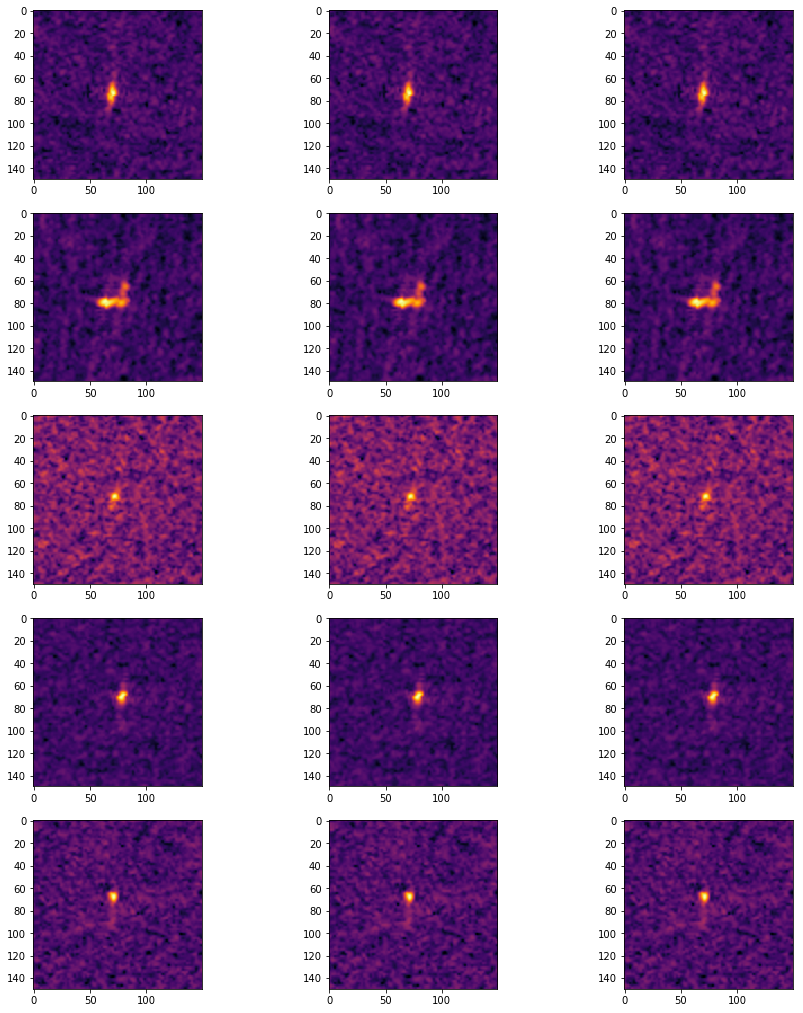

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot band_1
fig = plt.figure(1,figsize=(15,18))

for i in range(5):
    ax1 = fig.add_subplot(5, 3, i * 3 + 1)
    iceberg_band1 = blah_train[i, :, :, 0]
#     iceberg_band1 = np.reshape(np.array(icebergs.iloc[i,0]), (75, 75))
    ax2 = fig.add_subplot(5, 3, i * 3 + 2)
#     iceberg_band2 = np.reshape(np.array(icebergs.iloc[i,1]), (75, 75))
    iceberg_band2 = blah_train[i, :, :, 0]
    ax3 = fig.add_subplot(5, 3, i * 3 + 3)
    iceberg_combo = blah_train[i, :, :, 0]
#     iceberg_combo = (iceberg_band1 + iceberg_band2) / 2.

    ax1.imshow(iceberg_band1, cmap='inferno')
    ax2.imshow(iceberg_band2, cmap='inferno')
    ax3.imshow(iceberg_combo, cmap='inferno')
     
plt.show()

In [30]:
blah_train[0, :, :, 0].shape
blah_train[0, :, :, 1].shape
blah_train[0, :, :, 2].shape


(150, 150)